# **Elo Merchant Category Recommendation**



---



# Table of Contents


>*   [8. Improved Solution](#section8)
  *   [8.1. Splitting Features and Labels](#section8.1)
  *   [8.2. LGB Model with KFold](#section8.2)
      *   [8.2.1. Hyperparameter Tuning](#section8.2.1)
      *   [8.2.2. Model Building](#section8.2.2)
  *   [8.3. LGB Model with Repeated KFold](#section8.3)
      *   [8.3.1. Hyperparameter Tuning](#section8.3.1)
      *   [8.3.2. Model Building](#section8.3.2)
  *   [8.4. Summary](#section8.4)
  *   [8.5. Final Submission](#section8.5)








---



# Importing Libraries

In [1]:
# GPU setup for LGBM
! git clone --recursive https://github.com/Microsoft/LightGBM

Cloning into 'LightGBM'...
remote: Enumerating objects: 22625, done.
remote: Counting objects: 100% (238/238), done.
remote: Compressing objects: 100% (140/140), done.
remote: Total 22625 (delta 127), reused 163 (delta 93), pack-reused 22387
Receiving objects: 100% (22625/22625), 17.52 MiB | 28.76 MiB/s, done.
Resolving deltas: 100% (16575/16575), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/external_libs/compute'...
remote: Enumerating objects: 21731, done.        
remote: Counting objects: 100% (3/3), done.        
remote: Com

In [2]:
! cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;

-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Looking for CL_VERSION_2_2
-- Looking for CL_VERSION_2_2 - found
-- Found OpenCL: /usr/lib/x86_64-linux-gnu/libOpenCL.so (found version "2.2") 
-- OpenCL include directory: /usr/include
-- Boost version: 1.65.1
-- Found the following Boost libraries:
--

In [3]:
# importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from sklearn.metrics import mean_squared_error
from sklearn import model_selection, preprocessing, metrics
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RepeatedKFold, GridSearchCV, RandomizedSearchCV
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
from prettytable import PrettyTable
import gc
import pickle
import warnings
warnings.filterwarnings("ignore")

# Loading Datasets

In [4]:
#ref: https://www.kaggle.com/fabiendaniel/elo-world
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/Case Study 1/Data/Dataset/'
model_path = '/content/drive/MyDrive/Colab Notebooks/Case Study 1/Data/Model/'
result_path = '/content/drive/MyDrive/Colab Notebooks/Case Study 1/Data/Result/'

In [6]:
train = pd.read_csv(dataset_path + 'train_FE2.csv')
test = pd.read_csv(dataset_path + 'test_FE2.csv')

print('Shape of train data =', train.shape)
print('Shape of test data =', test.shape)

Shape of train data = (201917, 168)
Shape of test data = (123623, 166)


In [7]:
# reduce the memory of all datasets
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 78.95 Mb (69.5% reduction)
Mem. usage decreased to 47.75 Mb (69.5% reduction)


<a name='section8'><a/>
# 8. Improved Solution

In [8]:
train['target'] = train['target'].apply(lambda x: 1 if x > 0 else 0)

In [9]:
train['target'].value_counts()

0    104308
1     97609
Name: target, dtype: int64

In [10]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,month,year,dayofweek,weekofyear,elapsed_time,old_purchase_amount_sum,old_purchase_amount_max,old_purchase_amount_min,old_purchase_amount_mean,old_purchase_amount_var,old_purchase_amount_skew,old_installments_sum,old_installments_max,old_installments_mean,old_installments_var,old_installments_skew,old_purchase_date_max,old_purchase_date_min,old_month_lag_max,old_month_lag_min,old_month_lag_mean,old_month_lag_var,old_month_lag_skew,old_month_diff_max,old_month_diff_min,old_month_diff_mean,old_month_diff_var,old_month_diff_skew,old_weekend_sum,old_weekend_mean,old_weekday_sum,old_weekday_mean,old_authorized_flag_sum,old_authorized_flag_mean,...,new_hour_mean,new_hour_min,new_hour_max,new_weekofyear_nunique,new_weekofyear_mean,new_weekofyear_min,new_weekofyear_max,new_dayofweek_nunique,new_day_nunique,new_day_mean,new_day_min,new_day_max,new_subsector_id_nunique,new_merchant_id_nunique,new_merchant_category_id_nunique,new_price_sum,new_price_mean,new_price_max,new_price_min,new_price_var,new_duration_mean,new_duration_min,new_duration_max,new_duration_var,new_duration_skew,new_amount_month_ratio_mean,new_amount_month_ratio_min,new_amount_month_ratio_max,new_amount_month_ratio_var,new_amount_month_ratio_skew,new_category_2_mean_mean,new_category_3_mean_mean,new_purchase_date_diff,new_purchase_date_average,new_purchase_date_uptonow,old_first_buy,new_first_buy,card_id_total,purchase_amount_total,outliers
0,2017-06-01,C_ID_92a2005557,0.013145,0.008751,0.011429,0,6,2017,3,22,1487,-165.968735,2.258394,-0.739258,-0.638341,0.045003,10.242188,4,1,0.015381,0.015206,7.921875,1.519551e+09,1.498573e+09,0,-8,-3.912109,5.750000,0.065979,41,40,40.53125,0.250000,-0.124023,90,0.346191,835,3.210938,247.0,0.950195,...,12.867188,8.0,16.0,7.0,13.304688,10.0,17.0,7.0,17.0,16.437500,5.0,31.0,10.0,23.0,14.0,-inf,-inf,-inf,-inf,NaN,-23.296875,-29.515625,-11.843750,30.085054,0.887695,-0.014229,-0.018112,-0.007221,1.138449e-05,0.895508,-0.550293,-0.592773,54.0,2.347656,1154.0,26,277.0,283.0,-179.210922,0
1,2017-01-01,C_ID_3d0044924f,0.010712,0.011383,0.010284,1,1,2017,6,52,1638,-210.006332,4.630300,-0.742188,-0.600018,0.148200,8.812500,543,10,1.551758,2.282448,3.718750,1.517438e+09,1.483720e+09,0,-12,-5.031250,14.476562,-0.258057,42,41,41.46875,0.248657,0.184448,132,0.377197,1177,3.363281,339.0,0.968750,...,11.164062,6.0,17.0,4.0,9.000000,5.0,13.0,4.0,4.0,13.500000,1.0,30.0,4.0,6.0,5.0,-4.355469,-0.725911,-0.701660,-0.739258,0.000207,-30.125000,-31.046875,-28.765625,0.833826,0.681641,-0.017487,-0.017899,-0.017120,5.960464e-08,-0.262451,-0.550293,-0.606445,56.0,9.335938,1185.0,5,396.0,356.0,-214.361801,0
2,2016-08-01,C_ID_d639edf6cd,0.010612,0.008751,0.010284,1,8,2016,0,31,1791,-29.167391,-0.145847,-0.729980,-0.678311,0.007635,5.625000,0,0,0.000000,0.000000,0.000000,1.519758e+09,1.484123e+09,0,-13,-8.601562,14.765625,0.725586,41,40,40.31250,0.224854,0.771484,11,0.255859,142,3.302734,41.0,0.953613,...,17.000000,17.0,17.0,1.0,17.000000,17.0,17.0,1.0,1.0,28.000000,28.0,28.0,1.0,1.0,1.0,-inf,-inf,-inf,-inf,NaN,-28.000000,-28.000000,-28.000000,NaN,NaN,-0.017502,-0.017502,-0.017502,NaN,NaN,-0.548828,-0.592773,0.0,0.000000,1155.0,163,635.0,44.0,-29.867586,0
3,2017-09-01,C_ID_186d6a6901,0.010712,0.014168,0.010284,1,9,2017,4,35,1395,-49.491364,1.445596,-0.740723,-0.642745,0.068447,6.968750,84,3,1.090820,0.346890,0.776855,1.519818e+09,1.506443e+09,0,-5,-2.832031,3.248047,0.557617,41,40,40.37500,0.240967,0.461670,11,0.142822,215,2.792969,77.0,1.000000,...,13.000000,7.0,21.0,5.0,13.859375,10.0,16.0,4.0,7.0,13.140625,4.0,24.0,5.0,7.0,6.0,-3.520996,-0.502999,0.566895,-0.734375,0.225098,-26.906250,-30.109375,-22.671875,8.349981,0.736816,-0.016434,-0.017914,-0.014175,2.264977e-06,0.789062,-0.556641,-0.604492,41.0,5.855469,1165.0,25,187.0,84.0,-54.147614,0
4,2017-11-01,C_ID_cdbd2c0db2,0.008057,0.014168,0.010284,0,11,2017,2,44,1334,-48.687656,7.193041,-0.746094,-0.366073,1.828159,5.210938,182,12,1.368164,3.598086

<a name='section8.1'><a/>
## 8.1. Splitting features and labels

In [11]:
train_data_y = train['target'].values
train_data_x = train.drop(['card_id','first_active_month','target','outliers'], axis=1)

test_data_x = test.drop(['card_id','first_active_month'], axis=1)

print('Shape of final train data :', train_data_x.shape, train_data_y.shape)
print('Shape of final test data :', test_data_x.shape)

Shape of final train data : (201917, 164) (201917,)
Shape of final test data : (123623, 164)


In [12]:
# splitting data into train and val set
X_train, X_val, y_train, y_val = train_test_split(train_data_x, train_data_y, test_size=0.25, stratify=train_data_y)
print('Shape of Train Data:')
print(X_train.shape, y_train.shape)
print('-'*30)
print('Shape of Val Data:')
print(X_val.shape, y_val.shape)

Shape of Train Data:
(151437, 164) (151437,)
------------------------------
Shape of Val Data:
(50480, 164) (50480,)


<a name='section8.2'><a/>
## 8.2. LGB Model with KFold

In [13]:
# utility function to display plotly image 
# ref: https://stackoverflow.com/questions/54028965/how-to-display-plotly-outputs-in-google-collaboratory-notebooks
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

In [14]:
# utility function to perform batch wise prediction
def batch_predict(clf, data):

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])

    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

<a name='section8.2.1'><a/>
### 8.2.1. Hyperparameter Tuning

In [15]:
# hyperparameter tuning using random search for best 'max_depth' and best 'n_estimator'
# model = XGBClassifier()
model = LGBMClassifier(device = "gpu")
parameters = {'max_depth':[1, 5, 10, 50], 'n_estimators':[10, 100, 500]}

clf = RandomizedSearchCV(model, parameters, cv=3, scoring='roc_auc', return_train_score=True, n_jobs=-1)
clf.fit(X_train, y_train)
print('Best parameters =',clf.best_params_)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_max_depth'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
depth =  results['param_max_depth']
estimator = results['param_n_estimators']

# code to plot 3D image using plotly
configure_plotly_browser_state()
init_notebook_mode(connected=False)

trace1 = go.Scatter3d(x=estimator,y=depth,z=train_auc, name = 'Train')
trace2 = go.Scatter3d(x=estimator,y=depth,z=cv_auc, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(xaxis = dict(title='n_estimators'),
                                yaxis = dict(title='max_depth'),
                                zaxis = dict(title='AUC'),), title='Hyperparameters vs. AUC (Set-1)')

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='3d-scatter-colorscale')

#results.head()

Output hidden; open in https://colab.research.google.com to view.

<a name='section8.2.2'><a/>
### 8.2.2. Model Building

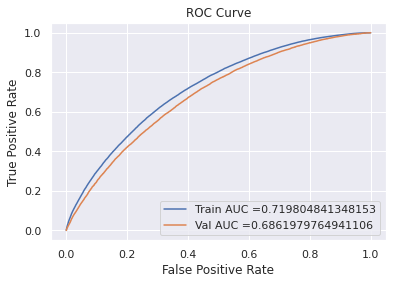

In [16]:
# training decision tree model with best hyperparameters
clf = clf.best_estimator_
clf.fit(X_train, y_train)

y_train_pred = batch_predict(clf, X_train)    
y_val_pred = batch_predict(clf, X_val)

train_fpr, train_tpr, train_thresh = roc_curve(y_train, y_train_pred)
val_fpr, val_tpr, val_thresh = roc_curve(y_val, y_val_pred)

# plotting ROC Curve 
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(val_fpr, val_tpr, label="Val AUC ="+str(auc(val_fpr, val_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [17]:
# utility function to find best threshold
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("The maximum value of tpr*(1-fpr) is", max(tpr*(1-fpr)), "for threshold of", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [18]:
# finding best threshold value
best_t = find_best_threshold(train_thresh, train_fpr, train_tpr)

# confusion matrix
train_cm = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
val_cm = confusion_matrix(y_val, predict_with_best_t(y_val_pred, best_t))

The maximum value of tpr*(1-fpr) is 0.43517566454543055 for threshold of 0.497


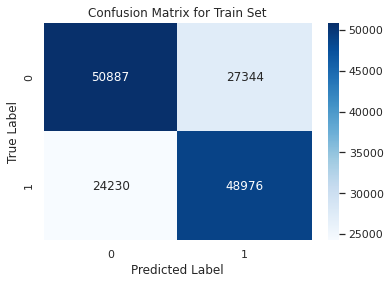

In [19]:
# plotting confusion matrix for test set
sns.heatmap(train_cm,annot=True,fmt="d",cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Train Set")
plt.show()

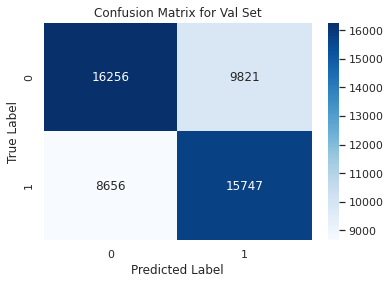

In [20]:
# plotting confusion matrix for test set
sns.heatmap(val_cm,annot=True,fmt="d",cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Val Set")
plt.show()

<a name='section8.4'><a/>
## 8.4. Summary

In [21]:
x = PrettyTable(['Model','Max Depth','N_Estimators','Train AUC','Val AUC'])
x.add_row(['LGBM', 10, 100, 0.71980, 0.68619])

print(x)

+-------+-----------+--------------+-----------+---------+
| Model | Max Depth | N_Estimators | Train AUC | Val AUC |
+-------+-----------+--------------+-----------+---------+
|  LGBM |     10    |     100      |   0.7198  | 0.68619 |
+-------+-----------+--------------+-----------+---------+


# References:

*   https://www.kaggle.com/c/elo-merchant-category-recommendation
*   https://stackoverflow.com/
*   https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

